In [1]:
import os

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from dotenv import load_dotenv
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/customer_churn_0.csv")

In [3]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [4]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
df.shape

(1050, 14)

In [6]:
len(df.isnull().sum().loc[lambda x: x > 0])

0

In [7]:
df.duplicated().sum()

np.int64(87)

In [8]:
def plot_numerical_variables(numerical_df):
    numerical_cols = numerical_df.select_dtypes(include=["float", "int"]).columns

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    _, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, col in enumerate(numerical_cols):
        sns.histplot(data=numerical_df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f"Distribution of {col}")
        axes[idx].tick_params(axis="x", rotation=45)
    # Hide any unused subplots
    for ax in axes[len(numerical_cols) :]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

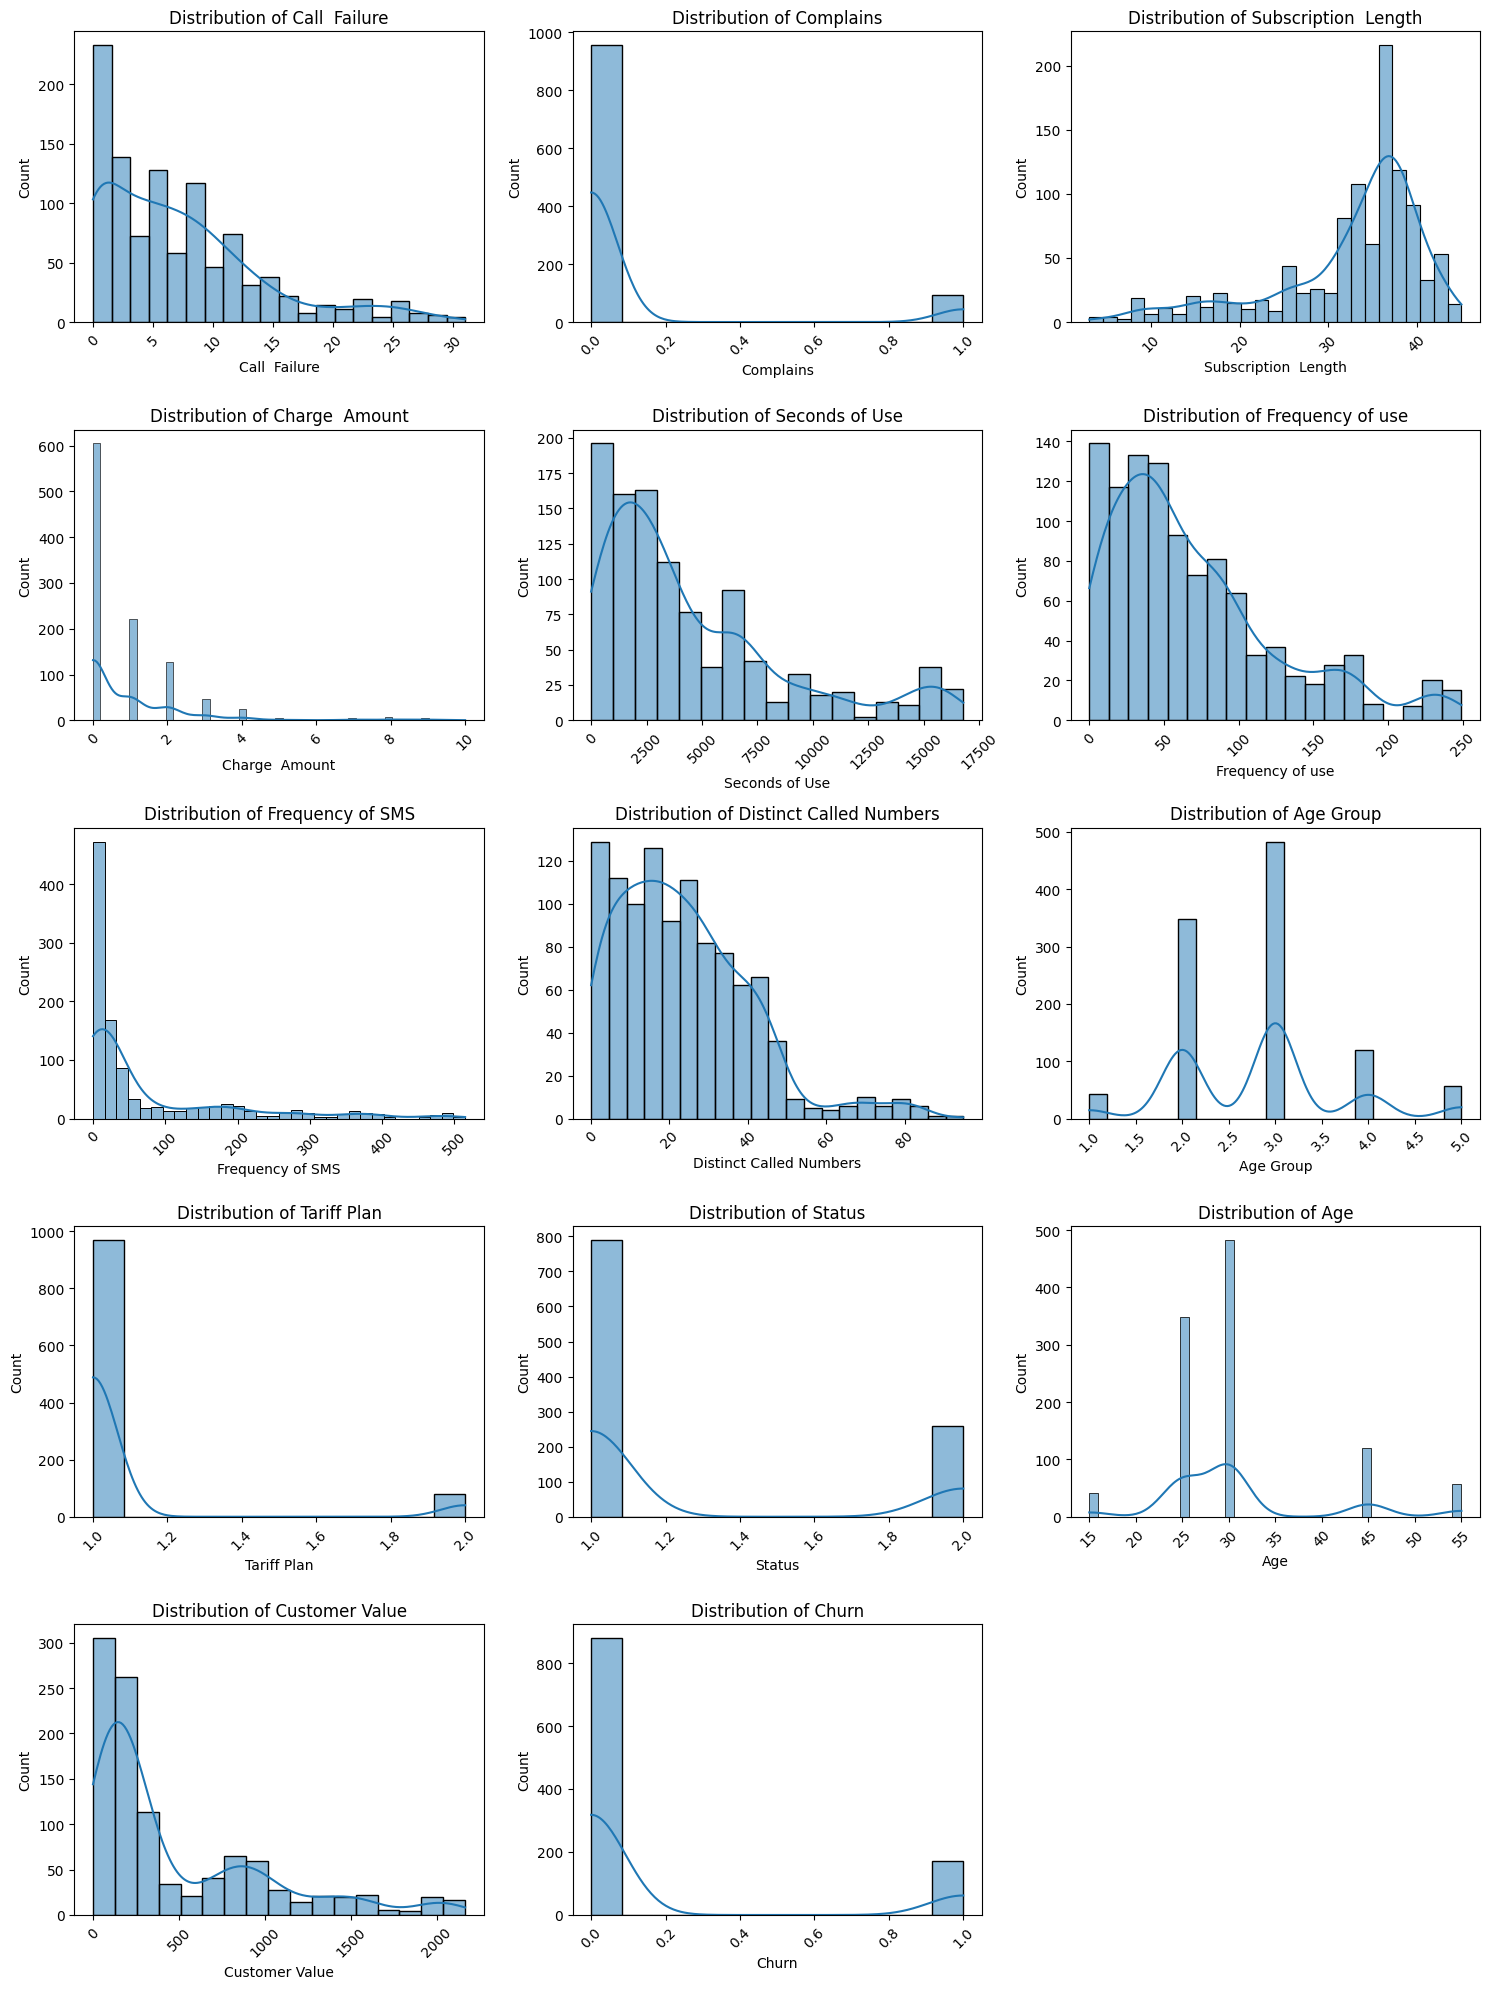

In [9]:
plot_numerical_variables(df)

In [10]:
load_dotenv()
MLFLOW_TRACKING_URI = os.getenv(
    "MLFLOW_TRACKING_URI"
)  # This should be set in your .env file
print(f"MLFLOW_TRACKING_URI: {MLFLOW_TRACKING_URI}")
if not MLFLOW_TRACKING_URI:
    raise ValueError("MLFLOW_TRACKING_URI is not set. Please check your .env file.")

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("mlops-churn-pipeline")

MLFLOW_TRACKING_URI: http://mlops-churn-pipeline-alb-1216481312.us-east-2.elb.amazonaws.com:5000


2025/07/13 21:56:07 INFO mlflow.tracking.fluent: Experiment with name 'mlops-churn-pipeline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlops-churn-pipeline/mlflow/1', creation_time=1752468969107, experiment_id='1', last_update_time=1752468969107, lifecycle_stage='active', name='mlops-churn-pipeline', tags={}>

In [11]:
def prepare_data(data_df):
    data_X = data_df.copy()
    data_y = data_X.pop("Churn")

    data_X = data_X.drop(columns=["Age", "Tariff Plan"])

    return data_X, data_y

In [12]:
X, y = prepare_data(df)

In [13]:
X.shape, y.shape

((1050, 11), (1050,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((840, 11), (210, 11), (840,), (210,))

In [16]:
def train_model(data_X, data_y, params):
    model = XGBClassifier(**params, objective="binary:logistic", eval_metric="logloss")
    model.fit(data_X, data_y)
    return model

In [17]:
base_params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.1,
    "random_state": 42,
}
clf = train_model(X_train, y_train, base_params)

In [18]:
def evaluate_model(
    model,
    data_X,
    data_y,
    dataset_name,
    log_model=False,
    log_model_X_train=None,
    log_model_y_train=None,
):
    with mlflow.start_run():
        mlflow.set_tag("dataset", dataset_name)

        print("Training model with the following features:")
        for idx, col in enumerate(data_X.columns):
            print(f"- Feature {idx}: {col}")
            mlflow.log_param(f"feature_{idx}", col)

        mlflow.log_params(model.get_xgb_params())

        y_pred = model.predict(data_X)

        logloss = log_loss(data_y, model.predict_proba(data_X))
        f1 = f1_score(data_y, y_pred)
        precision = precision_score(data_y, y_pred)
        recall = recall_score(data_y, y_pred)
        accuracy = accuracy_score(data_y, y_pred)

        print(f"\nMetrics for {dataset_name}:")
        print(f"log_loss: {logloss:.4f}")
        print(f"f1_score: {f1:.4f}")
        print(f"precision_score: {precision:.4f}")
        print(f"recall_score: {recall:.4f}")
        print(f"accuracy_score: {accuracy:.4f}")

        mlflow.log_metric("log_loss", logloss)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision_score", precision)
        mlflow.log_metric("recall_score", recall)
        mlflow.log_metric("accuracy_score", accuracy)

        print(f"\nClassification Report ({dataset_name}):")
        print(classification_report(data_y, y_pred))

        sns.heatmap(
            confusion_matrix(data_y, y_pred),
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix ({dataset_name})")
        plt.show()

        # Plot SHAP Summary
        explainer = shap.Explainer(model, data_X)
        shap.summary_plot(explainer(data_X), data_X, plot_type="dot", show=False)
        plt.title(f"SHAP Summary Plot ({dataset_name})")
        plt.tight_layout()
        plt.savefig(f"shap_summary_plot_{dataset_name}.png")
        mlflow.log_artifact(f"shap_summary_plot_{dataset_name}.png")
        plt.show()

        if log_model:

            # Save the model to MLflow model registry
            print("Logging model to MLflow...")
            logged_result = mlflow.xgboost.log_model(
                model,
                artifact_path="model",
                registered_model_name="XGBoostChurnModel",
                signature=infer_signature(data_X, y_pred),
                input_example=data_X.head(1),
            )

            # Log the training data
            print("Logging training data to MLflow...")
            train_data_path = "training_data.csv"
            log_model_X_train.assign(target=log_model_y_train).to_csv(
                train_data_path, index=False
            )
            mlflow.log_artifact(train_data_path, artifact_path="training_data")

            # Set the model alias to "staging" for easy retrieval in the pipeline
            print("Setting model alias to 'staging' in MLflow...")
            MlflowClient().set_registered_model_alias(
                "XGBoostChurnModel", "staging", logged_result.registered_model_version
            )

In [19]:
def tune_model_with_cv(data_X, data_y):

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 7),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 20.0),
            "tree_method": "hist",
            "eval_metric": "logloss",
        }

        model = XGBClassifier(**params)

        # Use stratified CV and recall scoring
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(
            model, data_X, data_y, scoring=make_scorer(recall_score), cv=cv, n_jobs=-1
        )

        return np.mean(scores)

    # Run the optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("\nBest hyperparameters found:")
    for key, value in study.best_params.items():
        print(f'"{key}": {value},')

    # Train final model with best hyperparameters on full dataset
    model = train_model(data_X, data_y, study.best_params)

    return model

In [20]:
# Uncomment the line below to run hyperparameter tuning
# clf = tune_model_with_cv(X_train, y_train)

In [21]:
# Train final model with best tuned hyperparameters to-date
# These parameters are based on the best results from previous tuning runs
# X_test precision/recall/f1: 0.92 0.81 0.86
best_params_to_date = {
    "n_estimators": 352,
    "learning_rate": 0.07154324375438634,
    "max_depth": 7,
    "min_child_weight": 1,
    "gamma": 0.23500630396472585,
    "subsample": 0.9472361823473306,
    "colsample_bytree": 0.6149847610884563,
    "reg_alpha": 0.029080723124195962,
    "reg_lambda": 1.9394489642211972,
}
clf = train_model(X_train, y_train, best_params_to_date)

Training model with the following features:
- Feature 0: Call  Failure
- Feature 1: Complains
- Feature 2: Subscription  Length
- Feature 3: Charge  Amount
- Feature 4: Seconds of Use
- Feature 5: Frequency of use
- Feature 6: Frequency of SMS
- Feature 7: Distinct Called Numbers
- Feature 8: Age Group
- Feature 9: Status
- Feature 10: Customer Value

Metrics for X_train:
log_loss: 0.0393
f1_score: 0.9807
precision_score: 0.9769
recall_score: 0.9845
accuracy_score: 0.9940

Classification Report (X_train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.98      0.98      0.98       129

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



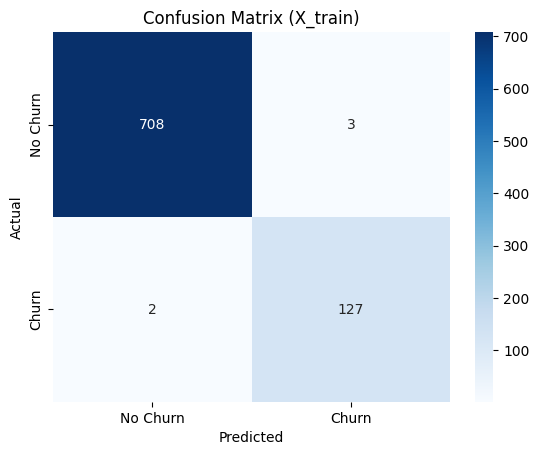

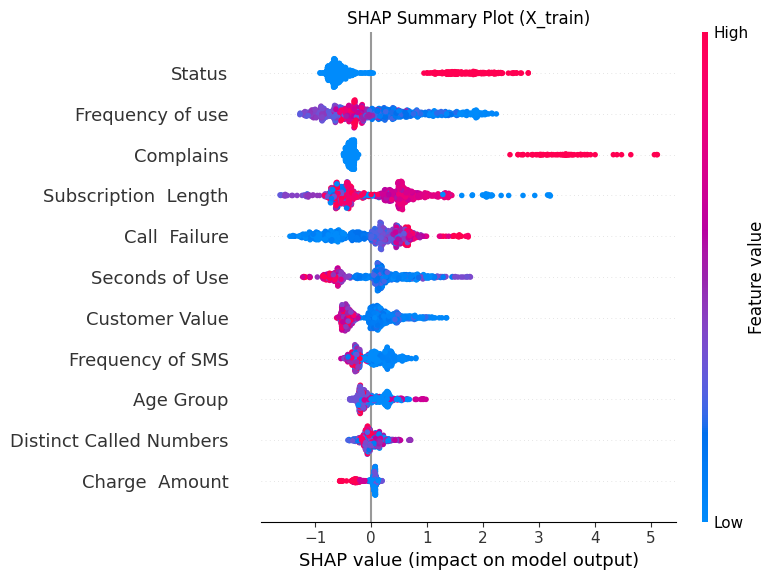

🏃 View run vaunted-duck-264 at: http://mlops-churn-pipeline-alb-1216481312.us-east-2.elb.amazonaws.com:5000/#/experiments/1/runs/ef1bc74c8ad5453fb11f1a8390994a23
🧪 View experiment at: http://mlops-churn-pipeline-alb-1216481312.us-east-2.elb.amazonaws.com:5000/#/experiments/1


In [22]:
# First evaluate tuned model on training data to check for bias
evaluate_model(clf, X_train, y_train, "X_train")

Training model with the following features:
- Feature 0: Call  Failure
- Feature 1: Complains
- Feature 2: Subscription  Length
- Feature 3: Charge  Amount
- Feature 4: Seconds of Use
- Feature 5: Frequency of use
- Feature 6: Frequency of SMS
- Feature 7: Distinct Called Numbers
- Feature 8: Age Group
- Feature 9: Status
- Feature 10: Customer Value

Metrics for X_test:
log_loss: 0.1617
f1_score: 0.8608
precision_score: 0.9189
recall_score: 0.8095
accuracy_score: 0.9476

Classification Report (X_test):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       168
           1       0.92      0.81      0.86        42

    accuracy                           0.95       210
   macro avg       0.94      0.90      0.91       210
weighted avg       0.95      0.95      0.95       210



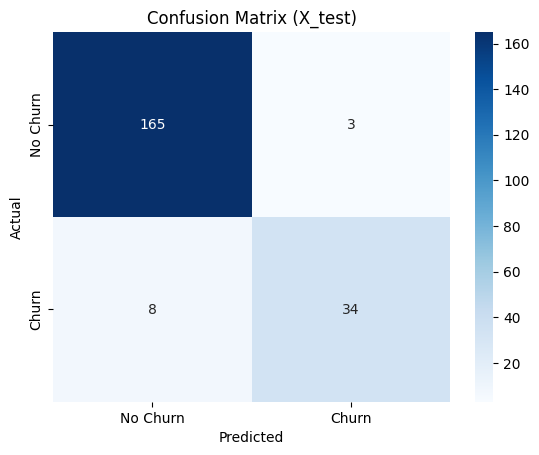

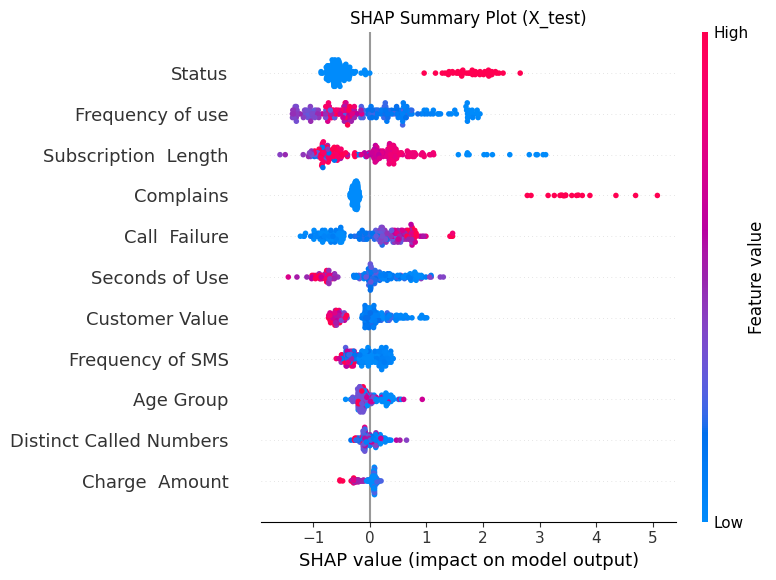

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/07/13 21:56:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging model to MLflow...


/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [21:56:22] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
Successfully registered model 'XGBoostChurnModel'.
2025/07/13 21:56:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostChurnModel, version 1
Created version '1' of model 'XGBoostChurnModel'.


Logging training data to MLflow...
Setting model alias to 'staging' in MLflow...
🏃 View run nervous-horse-214 at: http://mlops-churn-pipeline-alb-1216481312.us-east-2.elb.amazonaws.com:5000/#/experiments/1/runs/f78a9112639d4568b2b12a8fb9f1ee5f
🧪 View experiment at: http://mlops-churn-pipeline-alb-1216481312.us-east-2.elb.amazonaws.com:5000/#/experiments/1


In [23]:
# Next evaluate tuned model on test data to check for variance
evaluate_model(
    clf,
    X_test,
    y_test,
    "X_test",
    log_model=True,
    log_model_X_train=X_train,
    log_model_y_train=y_train,
)